# Ballooning Filter
This notebook is for prototyping a filter in ballooning space, used to generate synthetic global mode structures

## Import and Setup

In [15]:
# %% Imports
%load_ext autoreload
%autoreload 2

# numpy+scipy
import numpy as np
import scipy.interpolate
import scipy.integrate
import scipy.signal
import scipy.optimize
import scipy.special

# matplotlib+tqdm
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm.notebook import tqdm
#%matplotlib qt

# Data loading
from netCDF4 import Dataset

# c1lgkt codes
from c1lgkt.fields.equilibrium import Equilibrium
from c1lgkt.fields.field_handlers import XgcZonalFieldHandler, GaussHermiteFunction
from c1lgkt.fields.field_interpolators import sum_balloon_mode
from c1lgkt.fields.geometry_handlers import XgcGeomHandler
from c1lgkt.fields.utility import periodify
from c1lgkt.fields.field_analysis import upsample_fft_dpot

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
# %% Load data files
eq = Equilibrium.from_eqdfile(R'F:\Documents\IFS\hmode_jet\D3D141451.eqd')
xgcdata = Dataset(R'F:\Documents\Globus\XGC1.nc')

geom_files = {
    'ele_filename': R'F:\Documents\IFS\hmode_jet\Seo.eqd.ele',
    'fdmat_filename': R'F:\Documents\IFS\hmode_jet\fdmat.pkl',
    'min_e_filename': R'F:\Documents\IFS\hmode_jet\min_E_mat.pkl'
}
geom = XgcGeomHandler(eq, xgcdata, theta0_mode='midplane', **geom_files)

In [5]:
# %% Load the potential at one time point
tind = 400
dpot = xgcdata['dpot'][tind,:,:]
zonal_fields = XgcZonalFieldHandler(eq, xgcdata, tind)

## Computing FFTs

In [6]:
# %% Compute the upsampled FFT

# Range of surfaces to consider
ksurf0, ksurf1 = 1, geom.nsurf

# Compute the upsampled FFT of the potential
dpot_fft = upsample_fft_dpot(dpot, geom)

# Compute the upsampled FFT of the potential at the previous time step
dpot0_fft = upsample_fft_dpot(xgcdata['dpot'][tind-1,:,:], geom)

### Analysis

In [17]:
# %% Compute phase velocities and power spectra
dt = xgcdata['t'][tind] - xgcdata['t'][tind-1]

dpot_mult = np.zeros((ksurf1-ksurf0, dpot_fft.shape[0]), dtype=complex)
dpot_power = np.zeros((ksurf1-ksurf0, dpot_fft.shape[0]))

for k in range(ksurf0, ksurf1):
    # Get the upsampled FFT of the potential
    dpot_surf = dpot_fft[:,geom.breaks_surf[k]:geom.breaks_surf[k+1]]
    dpot0_surf = dpot0_fft[:,geom.breaks_surf[k]:geom.breaks_surf[k+1]]

    surf_weight = geom.surf_weight[geom.breaks_surf[k]:geom.breaks_surf[k+1]]

    # Compute the multiplier for one time index
    dpot_mult[k-ksurf0,:] = np.sum(dpot_surf * np.conj(dpot0_surf) * surf_weight[np.newaxis,:], axis=1) / np.sum(np.abs(dpot0_surf)**2 * surf_weight[np.newaxis,:], axis=1)

    # Compute the toroidal power spectrum
    dpot_power[k-ksurf0,:] = np.sum(np.abs(dpot_surf)**2 * surf_weight[np.newaxis,:], axis=1)


196


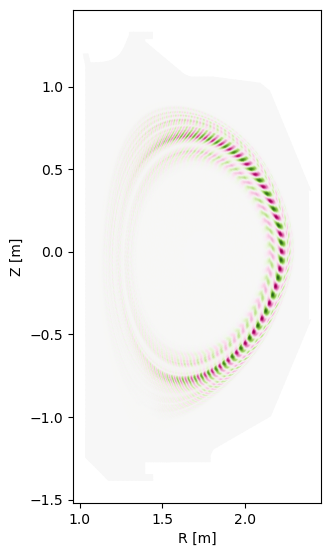

In [8]:
# %% Plot the FFT at a given n
plt.figure(figsize=(3.2,6.4))
plt.axis('equal')
plt.tripcolor(geom.rz_tri, np.real(dpot_fft[13,:]), shading='gouraud', rasterized=True, cmap='PiYG')

ksurf = np.searchsorted(-geom.q_surf, 2.0)
print(ksurf)
rz_surf = geom.rz_node[geom.breaks_surf[ksurf]:geom.breaks_surf[ksurf+1],:]
#plt.plot(rz_surf[:,0], rz_surf[:,1], c='k', ls=':')

plt.xlabel('R [m]')
plt.ylabel('Z [m]')

plt.savefig('./outputs/dpot_fft.pdf', dpi=300, bbox_inches='tight')

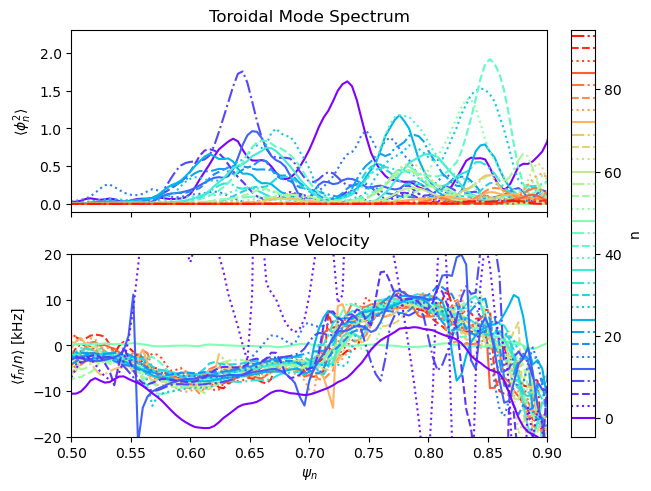

In [26]:
# %% Plot the power spectrum as a function of q

## Set up the figure via a subplot mosaic
fig = plt.figure(layout='constrained')
ax_dict = fig.subplot_mosaic(
    [
        ["power", "cax"],
        ["vph", "cax"],
    ],
    width_ratios=[1, 0.05],
    sharex=True,
)

ax = ax_dict['power']
cax = ax_dict['cax']
ax2 = ax_dict['vph']

## Function for setting the line styles
linestyles = ['solid', 'dotted', 'dashed', 'dashdot']
def nstyle(n):
    return {
        'linestyle': linestyles[n%4],
        'color': mpl.cm.rainbow(n/(dpot_fft.shape[0]-1)),
    }

## Plot the power spectrum and phase velocities
for n in range(0,dpot_power.shape[1]-1):
    ax.plot(geom.psi_surf[ksurf0:ksurf1-20]/eq.psix, np.abs(dpot_power[:-20,n]), **nstyle(n))
    cax.axhline(n*3, **nstyle(n))
for n in reversed(range(1,dpot_power.shape[1]-1)):
    ax2.plot(geom.psi_surf[ksurf0:ksurf1]/eq.psix, np.angle(dpot_mult[:,n])/(3*n)/dt*2*np.pi*1e-3, **nstyle(n))

# Add annotation lines to the plots
#ax.axvline(geom.psi_surf[ksurf]/eq.psix, c='k', ls=':')
#ax2.axvline(geom.psi_surf[ksurf]/eq.psix, c='k', ls=':')
ax2.plot(geom.psi_surf[ksurf0:ksurf1]/eq.psix, -zonal_fields.interp_phi(geom.psi_surf[ksurf0:ksurf1], nu=1)*2*np.pi*1e-3, c=mpl.cm.rainbow(0))
#ax2.axhline(0, c='k')
#cax.axhline(0, **nstyle(0))

## Set up labeling and such

# Set the cax tick labels to the right
cax.yaxis.set_ticks_position('right')
cax.yaxis.set_label_position('right')
cax.set_ylabel('n')
cax.xaxis.set_visible(False)

# Axis limits
ax.set_xlim(0.5,0.9)
ax2.set_ylim(-20,20)

# Axis labels
ax2.set_xlabel(R'$\psi_n$')
ax.set_ylabel(R'$\langle\phi_n^2\rangle$')
ax2.set_ylabel(R'$\langle f_n / n \rangle$ [kHz]')
ax.set_title('Toroidal Mode Spectrum')
ax2.set_title('Phase Velocity')

## Save data and figure
np.savez('./outputs/dpot_spectra.npz', dpot_power=dpot_power, dpot_mult=dpot_mult)

plt.savefig('./outputs/dpot_spectra.pdf', dpi=300, bbox_inches='tight')


## Compute Resampled Potential

In [27]:
# %% Resample onto regular grid in q, theta

# Pick an nphi to focus on. NOTE: ntor = 3*nphi
nphi = 13

# First, resample each flux surface into a regular grid in theta
theta_samp = np.linspace(-np.pi, np.pi, 1024, endpoint=False)

dpot_samp = np.zeros((len(theta_samp), ksurf1-ksurf0), dtype=complex)

for k in tqdm(range(ksurf0,ksurf1)):
    theta_surf = geom.theta_node[geom.breaks_surf[k]:geom.breaks_surf[k+1]]
    
    dpot_surf = dpot_fft[nphi,geom.breaks_surf[k]:geom.breaks_surf[k+1]]
    
    dpot_interp = scipy.interpolate.CubicSpline(periodify(theta_surf), periodify(dpot_surf, period=0), bc_type='periodic')
    
    dpot_samp[:,k-ksurf0] = dpot_interp(theta_samp)

# Next, resample each q surface into a regular grid in q
q_samp = np.linspace(geom.interp_q(geom.psi_surf[ksurf0]), geom.interp_q(geom.psi_surf[ksurf1-1]), 512)[::-1]

dpot_grid = np.zeros((len(theta_samp), len(q_samp)), dtype=complex)

for j in tqdm(range(len(theta_samp))):
    dpot_interp = scipy.interpolate.CubicSpline(-geom.interp_q(geom.psi_surf[ksurf0:ksurf1]), dpot_samp[j,:])
    
    dpot_grid[j,:] = dpot_interp(-q_samp)

q_grid, theta_grid = np.meshgrid(q_samp, theta_samp)

## Compute the envelope assumuing the strong ballooning limit
inv_eikonal = np.exp(1j*(3*nphi)*(q_samp[np.newaxis,:])*theta_samp[:,np.newaxis])
dpot_grid_env = dpot_grid*inv_eikonal

  0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

### Analysis

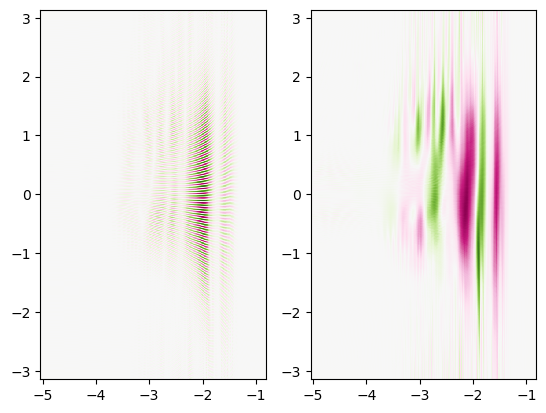

In [28]:
# %% Plot the resampled potential

plt.figure()

# Resampled potential
ax = plt.subplot(121)
plt.pcolormesh(q_samp, theta_samp, np.real(dpot_grid), norm=mpl.colors.CenteredNorm(), cmap='PiYG')

# Resampled potential removing the eikonal
plt.subplot(122, sharex=ax, sharey=ax)
plt.pcolormesh(q_samp, theta_samp, np.real(dpot_grid_env), norm=mpl.colors.CenteredNorm(), cmap='PiYG')

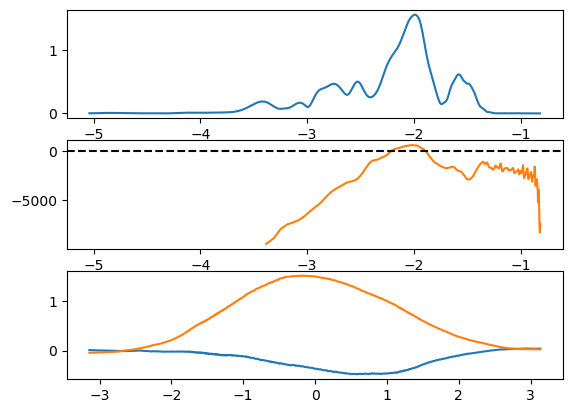

In [29]:
# %% Plot of envelope and mode structure

plt.figure()

ax = plt.subplot(311)
plt.plot(q_samp, np.abs(dpot_grid_env[len(theta_samp)//2,:]))

plt.subplot(312, sharex=ax)
plt.plot(geom.q_surf[:240], -zonal_fields.interp_phi(geom.psi_surf[:240], nu=1), c='tab:orange')
plt.axhline(0, c='k', ls='--')

# Peak of the envelope
env_qind_max = np.argmax(np.abs(dpot_grid_env[len(theta_samp)//2,:]))

plt.subplot(313)
plt.plot(theta_samp, np.real(dpot_grid_env[:,env_qind_max]))
plt.plot(theta_samp, np.imag(dpot_grid_env[:,env_qind_max]))

## Fitting Ballooning Mode

In [46]:
# %% Perform a Gaussian fit

## q range to fit
q_inds = np.searchsorted(q_samp, [-2.3, -1.8])

# Flatten the data
theta_data = theta_grid[:,q_inds[0]:q_inds[1]].flatten()
q_data = q_grid[:,q_inds[0]:q_inds[1]].flatten()
dpot_data = dpot_grid[:,q_inds[0]:q_inds[1]].flatten()

## Initial guess
# Take the maximum of the envelope
env_qind_max = np.argmax(np.abs(dpot_grid_env[len(theta_samp)//2,:]))
mu_q0 = q_samp[env_qind_max]
env_thind_max = np.argmax(np.abs(dpot_grid_env[:,env_qind_max]))
mu_theta0 = theta_samp[env_thind_max]
a00_r = np.real(dpot_grid_env[env_thind_max,env_qind_max])
a00_i = np.imag(dpot_grid_env[env_thind_max,env_qind_max])

params0 = np.array([mu_q0, mu_theta0, 0.12, np.pi/4, a00_r, a00_i])
params00 = np.array([mu_q0, mu_theta0, 0.12, np.pi/4, a00_r, a00_i])

## First-pass fit that uses only the Gaussian

# Define objective function
def objective_function_gaussian(params):
    gauss_balloon = GaussHermiteFunction(params[:4], params[4:])
    pot_trial = sum_balloon_mode(q_data, theta_data, 1, 3*nphi, gauss_balloon, False)
    return np.log(np.sum(np.abs(pot_trial - dpot_data)**2))

res_g = scipy.optimize.minimize(objective_function_gaussian, params0)
print(res_g.message)


## Next-pass fit; keep the location/scale parameters fixed while varying the Gauss-Hermite coefficients
params_g = res_g.x[:4]

# Define the order of the coefficients
def objective_function_ghermite(params):
    ghermite_balloon = GaussHermiteFunction(params_g, params)
    pot_trial = sum_balloon_mode(q_data, theta_data, 1, 3*nphi, ghermite_balloon, False)
    return np.log(np.sum(np.abs(pot_trial - dpot_data)**2))

params0 = np.concatenate((res_g.x[4:], np.zeros(10)))
res_gh = scipy.optimize.minimize(objective_function_ghermite, params0)
print(res_gh.message)

Desired error not necessarily achieved due to precision loss.
Optimization terminated successfully.


In [44]:
print(res_g.x)
print(params00)

[-6.44823537e-01  1.02084770e+00  6.70774564e-01 -2.99559234e-04
 -1.71236630e-01  8.65081574e-01]
[-1.99239089 -0.19634954  0.1         0.78539816 -0.31933622  1.52848211]


### Plots

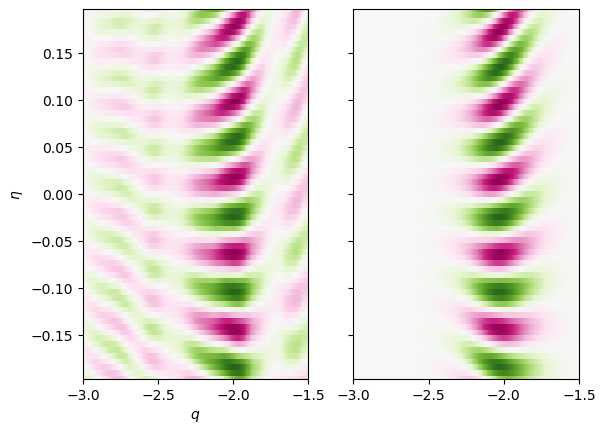

In [54]:
# %% Plot the result
dpot_fit_g = sum_balloon_mode(q_grid, theta_grid, 1, 3*nphi, GaussHermiteFunction(res_g.x[:4], res_g.x[4:]), False)
dpot_fit_gh = sum_balloon_mode(q_grid, theta_grid, 1, 3*nphi, GaussHermiteFunction(res_g.x[:4], res_gh.x), False)

#dpot_fit_gh = sum_balloon_mode(q_grid, theta_grid, 1, 3*nphi, GaussHermiteFunction(params00[:4], params00[4:]), False)

fig, axs = plt.subplots(1, 2, sharex=True, sharey=True)

q_range = (-3, -1.5)
theta_range = (-np.pi/16, np.pi/16)

q_inds = np.searchsorted(q_samp, [q_range[0] - 0.1, q_range[1] + 0.1])
theta_inds = np.searchsorted(theta_samp, [theta_range[0] - 0.1, theta_range[1] + 0.1])

axs[0].pcolormesh(
    q_samp[q_inds[0]:q_inds[1]],
    theta_samp[theta_inds[0]:theta_inds[1]],
    np.real(dpot_grid)[theta_inds[0]:theta_inds[1], q_inds[0]:q_inds[1]],
    norm=mpl.colors.CenteredNorm(), cmap='PiYG', rasterized=True)
axs[1].pcolormesh(
    q_samp[q_inds[0]:q_inds[1]],
    theta_samp[theta_inds[0]:theta_inds[1]],
    np.real(dpot_fit_gh)[theta_inds[0]:theta_inds[1], q_inds[0]:q_inds[1]],
    norm=mpl.colors.CenteredNorm(), cmap='PiYG', rasterized=True)

axs[0].set_xlabel(R'$q$')
axs[0].set_ylabel(R'$\eta$')
axs[0].set_xlim(q_range)
axs[0].set_ylim(theta_range)

plt.savefig('./outputs/dpot_fit.pdf', dpi=300, bbox_inches='tight')

### Save Results

In [ ]:
#np.savez('./outputs/fit_results.npz', params_g=res_g.x, params_gh=res_gh.x)

## Gyroaveraging Tests

In [168]:
# %% Compute the magnetic moment

import c1lgkt.particles.particle_motion as particle_motion

## Choose which particle properties to use
pp = particle_motion.deut

## Set initial position
#r0 = 2.2259
r0 = eq.interp_router(geom.psi_surf[ksurf]/eq.psix)
z0 = geom.zaxis
x0 = np.array([r0, 0.0, z0])

# Compute magnetic field at initial position
bv = eq.compute_bv(x0[0], x0[2])
modb = np.linalg.norm(bv)
bu = bv / modb

# Initial magnetic moment
mu0 = pp.m * (np.sqrt(0.67)*pp.vt)**2 / 2 / modb

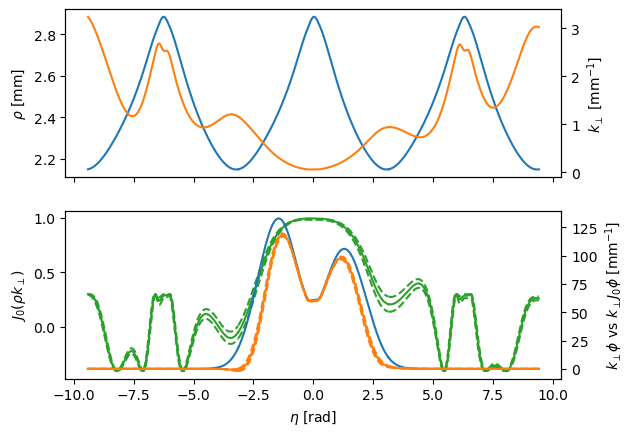

In [169]:
# %% Compute J0 along the field line

# Compute rho along the surface
rz_surf = geom.rz_node[geom.breaks_surf[ksurf]:geom.breaks_surf[ksurf+1],:]
b_surf = geom.b_node[geom.breaks_surf[ksurf]:geom.breaks_surf[ksurf+1],:]
theta_surf = geom.theta_node[geom.breaks_surf[ksurf]:geom.breaks_surf[ksurf+1]]
modb = np.linalg.norm(b_surf, axis=1)
rho = np.sqrt(2 * mu0 * modb * pp.m) / modb / np.abs(pp.z)

## Compute kperp along the surface

# Extract R and Z
r = rz_surf[:,0]
z = rz_surf[:,1]
# Get psi on the surface
psi_ev, ff_ev = eq.compute_psi_and_ff(r, z)
(psi, psidr, psidz, psidrr, psidrz, psidzz) = psi_ev
# Compute geometric theta and use it in the interpolator
gtheta = np.arctan2(z - eq.zaxis, r - eq.raxis)
gdtheta, dgdtheta = geom.interp_gdtheta_grid(psi, gtheta, nu=(0,1))

fig, axs = plt.subplots(2, 1, sharex=True)
axt = [axs[0].twinx(), axs[1].twinx()]

ntor = 3*nphi
mu_q, mu_eta, sigma_q, sigma_eta = res_g.x[:4]
sigma_thetak = 1 / (ntor*sigma_q)

l = 0
for l in [-1, 0, 1]:
    eta = np.mod(gtheta + gdtheta + np.pi, 2*np.pi) - np.pi + l*2*np.pi

    # dq/dpsi, used to compute grad(q)
    q = geom.interp_q(psi)
    dq = geom.interp_q(psi, nu=1)

    # geometric minor radius squared
    rg2 = (r - eq.raxis)**2 + (z - eq.zaxis)**2
    # Compute grad(eta)
    thetagr = (eq.zaxis - z) / rg2
    thetagz = (r - eq.raxis) / rg2
    etar = (1 + dgdtheta[1,:]) * thetagr + dgdtheta[0,:] * psidr
    etaz = (1 + dgdtheta[1,:]) * thetagz + dgdtheta[0,:] * psidz

    # compute kR and kZ
    kr = ntor * (-q * etar - (eta) * dq * psidr)
    kz = ntor * (-q * etaz - (eta) * dq * psidz)
    kphi = ntor / r
    kperp = np.sqrt(kr**2 + kz**2 + kphi**2)

    # Permutation to plot theta in order
    p = np.argsort(eta)

    ## Make plots
    axs[0].plot(eta[p], rho[p]*1e3, c='tab:blue')
    axs[0].set_ylabel(R'$\rho$ [mm]')

    axt[0].plot(eta[p], kperp[p] / 1e3, c='tab:orange')
    axt[0].set_ylabel(R'$k_\perp$ [mm$^{-1}$]')

    axs[1].plot(eta[p], scipy.special.jv(0, rho[p] * kperp[p]), c='tab:green')
    axs[1].set_ylabel(R'$J_0(\rho k_\perp)$')

    axt[1].plot(eta[p], np.exp(-(eta[p] - mu_eta)**2 / (2*sigma_eta**2)) * kperp[p], c='tab:blue')
    axt[1].plot(eta[p], np.exp(-(eta[p] - mu_eta)**2 / (2*sigma_eta**2)) * scipy.special.jv(0, rho[p] * kperp[p]) * kperp[p], c='tab:orange')

    axs[1].set_xlabel(R'$\eta$ [rad]')
    axt[1].set_ylabel(R'$k_\perp \phi$ vs $k_\perp J_0 \phi$ [mm$^{-1}$]')

    # Check how much changing theta_k changes things
    for thetak in [-sigma_thetak, sigma_thetak]:
        kr = ntor * (-q * etar - (eta - thetak) * dq * psidr)
        kz = ntor * (-q * etaz - (eta - thetak) * dq * psidz)
        kphi = ntor / r
        kperp2 = np.sqrt(kr**2 + kz**2 + kphi**2)

        axs[1].plot(eta[p], scipy.special.jv(0, rho[p] * kperp2[p]), c='tab:green', ls='--')
        axt[1].plot(eta[p], np.exp(-(eta[p] - mu_eta)**2 / (2*sigma_eta**2)) * scipy.special.jv(0, rho[p] * kperp2[p]) * kperp[p], c='tab:orange', ls='--')

In [ ]:
# %% Test the gyroaveraging operator